# Imports

In [143]:
import cv2
import sys
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
import time
import argparse
import shutil
from io import StringIO
import string
from termcolor import colored, cprint
import math as m
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler
# Don't generate pyc codes
sys.dont_write_bytecode = True

import tensorflow as tf

from keras import backend as K

from keras.utils import Sequence
from keras.initializers import VarianceScaling
from keras.models import Sequential
from keras.layers import  Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
from Misc.TFSpatialTransformer import transformer
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Define Functions

In [144]:
def getCornersFromH4pt(corner1, H4pt):
    corners1 = np.array(corner1.copy())
    del_corners = H4pt.reshape(2,4).T
    corners2 = corners1 + del_corners
    return corners2

def drawCorners(image, corners, color):

    corners_ = np.array(corners.copy())
    r = corners_[2,:].copy()
    corners_[2,:] = corners_[3,:]
    corners_[3,:] = r
    corners_ = corners_.reshape(-1,1,2)
#     print(corners_)
    corners_ = corners_.astype(int)
    image_corners = cv2.polylines(image.copy(),[corners_],True,color, 4)
    return image_corners

def getHfromH4pt(corners1, H4pt):
#     print("H4pt is: ")
#     print(H4pt.reshape(2,4).T)

    del_corners = H4pt.reshape(2,4).T
    
    corners1 = np.array(corners1)
#     print("corner1 is: ")
#     print(corners1)

    corners2 = corners1 + del_corners
#     print("corner2 is: ")
#     print(corners2)

    H = cv2.getPerspectiveTransform(np.float32(corners1), np.float32(corners2))
#     print("H is:")
#     print(H)
    return H

def warpImage(img, corners, H):
    image = img.copy()
    h, w, _= image.shape

    corners_ = np.array(corners)
    corners_ = corners_.reshape((-1,1,2))

    image_transformed = cv2.warpPerspective(image, H, (w,h))
    corner_transformed = cv2.perspectiveTransform(np.float32(corners_), H)
    corner_transformed = corner_transformed.astype(int)
    
    return image_transformed, corner_transformed

def HomographyNet():

#     hidden_layer_size, num_classes = 1000, 8
    input_shape = (128, 128, 2)
    kernel_size = 3
    pool_size = 2
    filters = 64
    dropout = 0.5

    kernel_initializer = VarianceScaling(scale=2.0)
    
    model = Sequential()
    model.add(InputLayer(input_shape))
    ## conv2d 128
    model.add(Conv2D(filters=filters,kernel_size = kernel_size, activation ='relu', padding ='same'))
    model.add(BatchNormalization())
    
    ## conv2d 128
    model.add(Conv2D(filters = filters,kernel_size = kernel_size, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 64
    model.add(Conv2D(filters=filters,kernel_size=kernel_size, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    ## conv2d 64
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 32 2x Filters
    model.add(Conv2D(filters=filters*2,kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    ## conv2d 32 2x Filters
    model.add(Conv2D(filters=filters*2,kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 16 2x Filters
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    ## conv2d 16 2x Filters
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))
    #for regression model
    model.add(Dense(8))
    return model

#Loss Function using SMSE
def L2_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

# Read Files and Load training Data 
-- all data in memory, not in batches

In [184]:

path = '/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Val_synthetic/'
pointsList = np.load(path+'pointsList.npy')
all_labels = pd.read_csv(path+'H4.csv', index_col = False)
all_labels = all_labels.to_numpy()
print(pointsList.shape, all_labels.shape)
all_patchNames = pd.read_csv(path + "ImageFileNames.csv")
all_patchNames = all_patchNames.to_numpy()

n  =10
X_train = []
for i, p in enumerate(all_patchNames[:n]):

    tPatchA = cv2.imread(path+"PA/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatchB = cv2.imread(path+"PB/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatch = np.dstack((tPatchA, tPatchB))    
    X_train.append(tPatch)
X_train = np.array(X_train)    
Y_train = all_labels[:n]

print(X_train.shape,Y_train.shape)

corners_a = pointsList[:n,:,:,0]
corners_b = pointsList[:n,:,:,1]

print(corners_a.shape,corners_b.shape)

(4995, 4, 2, 2) (4995, 8)
(10, 128, 128, 2) (10, 8)
(10, 4, 2) (10, 4, 2)


# Train the model, save and test

# Design Unsupervised Model


In [185]:
# def unSuperVised( Img,) :

# note : corners_a is in shape 4,2 [[x1,y1][x2,y2][x3,y3][x4,y4]]

# H4 = homographyNet(Img, ImageSize, batch_size) # H4 = [dx1,dy1,dx2,dy2,dx3,dy3,dx4,dy4] 

# batch_size = 1
# corners_a = np.array([[1,2],[3,4],[5,6],[7,8]])
# corners_a = tf.constant(corners_a, tf.float32)
# H4 = tf.constant([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], tf.float32)

batch_size,h,w,channels =  X_train.shape

X_train = tf.constant(X_train, tf.float32)
batch_size,h,w,channels = X_train.get_shape()

corners_a = tf.constant(corners_a, tf.float32)
H4 = tf.constant(Y_train, tf.float32)
corners_a = tf.reshape(corners_a,[batch_size,8]) # convert to 8x1 [x1,y1,x2,y2,x3,y3,x4,y4]

# H = TensorDLT(H4 , corners_a, batch_size)
H = np.array([[2.0, 0., 2.0],
              [0., 2.0, 2.0],
              [0., 0., 1.]]).astype(np.float32)
tensor_H = tf.constant(H, tf.float32) # tensorH
tensor_H = tf.expand_dims(tensor_H, [0])
H_batches   = tf.tile(tensor_H, [batch_size, 1,1]) # make batch_size number of copies. 



# h,w = ImageSize[1],ImageSize[0]

M = np.array([[w/2.0, 0., w/2.0],
              [0., h/2.0, h/2.0],
              [0., 0., 1.]]).astype(np.float32)

tensor_M = tf.constant(M, tf.float32)
tensor_M = tf.expand_dims(tensor_M, [0])
M_batches   = tf.tile(tensor_M, [batch_size, 1,1]) # make batch_size number of copies. 

M_inv = np.linalg.inv(M)
tensor_M_inv = tf.constant(M_inv, tf.float32)
tensor_M_inv = tf.expand_dims(tensor_M_inv, [0])
M_inv_batches   = tf.tile(tensor_M_inv, [batch_size,1,1])

H_scaled = tf.matmul(tf.matmul(M_inv_batches, H_batches), M_batches)
Pa = tf.slice(X_train,[0,0,0,0],[batch_size,w,h,1])
Pb = tf.slice(X_train,[0,0,0,1],[batch_size,w,h,1])

warped_a, _ = transformer(Pa, H_batches, (h,w))

# warped_a = tf.reshape(warped_a, [batch_size, h, w, 1])



TypeError: unsupported operand type(s) for /: 'Dimension' and 'float', please use // instead

In [181]:
batch_size

Dimension(10)

In [166]:
print(tf.Session().run(X_train).shape)
print(tf.Session().run(pred_I2).shape)
print(tf.Session().run(warped_a).shape)

(10, 128, 128, 2)
(10, 128, 128, 1)
(10, 128, 128, 1)


(10, 128, 128) (10, 128, 128) (10, 128, 128)


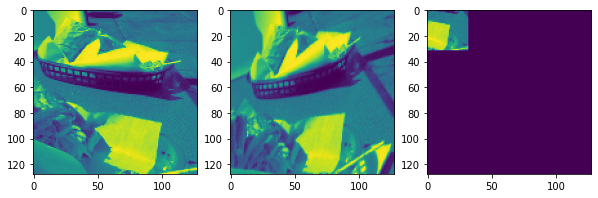

In [162]:
PA = tf.Session().run(Pa).squeeze()
PB = tf.Session().run(Pb).squeeze()
warped_PA = tf.Session().run(warped_a).squeeze()
print(PA.shape,PB.shape,warped_PA.shape)

i=3
x, plts = plt.subplots(1,3,figsize = (10,10))
plts[0].imshow(PA[i,:,:])
plts[1].imshow(PB[i,:,:])
plts[2].imshow(warped_PA[i,:,:])

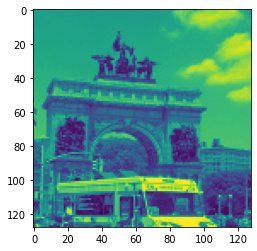

In [112]:
P = tf.Session().run(Pa).squeeze()
print(PA.shape)
plt.imshow(PA[0,:,:])
plt.imshow(PA[0,:,:])

In [54]:
I1 = tf.slice(Img,[0,0,0,0],[MiniBatchSize,128,128,1])

print(I1)
print(Img)
warped_images, _ = transformer(I1, H_mat, out_size)
# print(warped_images.get_shape())
warped_gray_images = tf.reduce_mean(warped_images, 3)

pred_I2_flat = warped_gray_images

pred_I2 = tf.reshape(pred_I2_flat, [MiniBatchSize, 128, 128, 1])

[0 0 0 ... 0 0 0]
(16384,)


In [3]:



M_tile   = tf.tile(, [batch_size, 1,1])

print(C4A.get_shape())

NameError: name 'np' is not defined

### Load model predict H4 and convert to H